### SVD Project UMN Financial Math 5092

##### Overview

    Over the last decade, facial recognition technology has improved as the availability of big data and cloud computing has grown. This project seizes on a few of these technologies and evaluates the effectiveness of Single Value Decomposition on a picture taken on a COVID-19 quarantined walk with the dogs. Single Value Decomposition is common in image compression because it allows images to be saved with less data. This project evaluates how much image compression is too much compression for the Dlib-ml shape detector.

##### References 

Davis E. King. Dlib-ml: A Machine Learning Toolkit. Journal of Machine Learning Research 10, pp. 1755-1758, 2009

Rosebrock, Adrian. “Facial Landmarks with Dlib, OpenCV, and Python.” Pyimagesearch, 3 Apr. 2017, www.pyimagesearch.com/2017/04/03/facial-landmarks-dlib-opencv-python/.

Bradski, G. “The OpenCV Library.” Dr. Dobb's Journal of Software Tools, 15 Jan. 2008.

John D. Hunter. Matplotlib: A 2D Graphics Environment, Computing in Science & Engineering, 9, 90-95 (2007)

B. Amos, B. Ludwiczuk, M. Satyanarayanan,
"Openface: A general-purpose face recognition library with mobile applications,"
CMU-CS-16-118, CMU School of Computer Science, Tech. Rep., 2016.


Begin by importing python libraries

In [1]:
# import the necessary packages
from imutils import face_utils
import numpy as np
import argparse
import imutils
import dlib
import cv2
import openface
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

Below are a few functions Adrian Rosebrock created to help visualize results

In [2]:
def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((68, 2), dtype=dtype)
    # loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)
    # return the list of (x, y)-coordinates
    return coords
def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it
    # to the format (x, y, w, h) as we would normally do
    # with OpenCV
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y
    # return a tuple of (x, y, w, h)
    return (x, y, w, h)


Here is a SVD reconstruction function using the dot function in numpy

In [3]:
def reconstruct_image(U,S,Vt):
    """Matrix multiplication U*S*Vt"""
    return np.dot(np.dot(U,np.append(np.diag(S),np.zeros(len(S)).reshape(len(S),1),axis=1)),Vt)
def reduced_image(U,S,Vt,n):
    """Reduce image to n dimensions then, Matrix multiplication U*S*Vt"""
    s=np.concatenate((S[:n],np.zeros(len(S[n:]))))
    return reconstruct_image(U,s,Vt)

This section loads the pretrained face detection and landmark recognition models

In [4]:
# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

Now we can load the image from our COVID-19 walk and resize it to a 500x500 array. This will be our M matrix

What is shown below as a color image is actually 3 1108x1186 matrixes


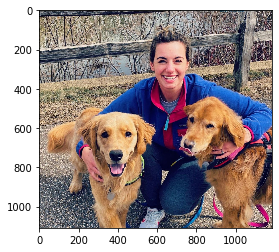

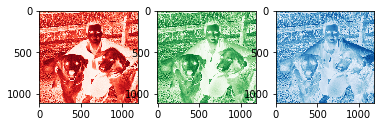

In [5]:
img=openface.data.Image("Kate","Original",os.getcwd()+"/RawPhotos/Original.jpg")
image=img.getRGB()
image = imutils.resize(image)
plt.imshow(image)
print("What is shown below as a color image is actually {0} {1}x{2} matrixes".format(image.shape[2],image.shape[0],image.shape[1]))
fig, plot = plt.subplots(1,3)
plot[0].imshow(image[:,:,0], cmap='Reds')
plot[1].imshow(image[:,:,1], cmap='Greens')
plot[2].imshow(image[:,:,2], cmap='Blues')

Converting the image to grayscale 
gives us 1 1108 x 1186 matrix M
for single value decomposition


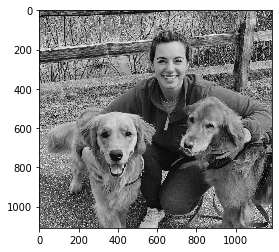

In [6]:
print("""Converting the image to grayscale 
gives us 1 {0} x {1} matrix M
for single value decomposition""".format(image.shape[0],image.shape[1]))
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap="gray")

Now that we have a grayscale image we can use the dlib face detector to put a box around the faces in this image

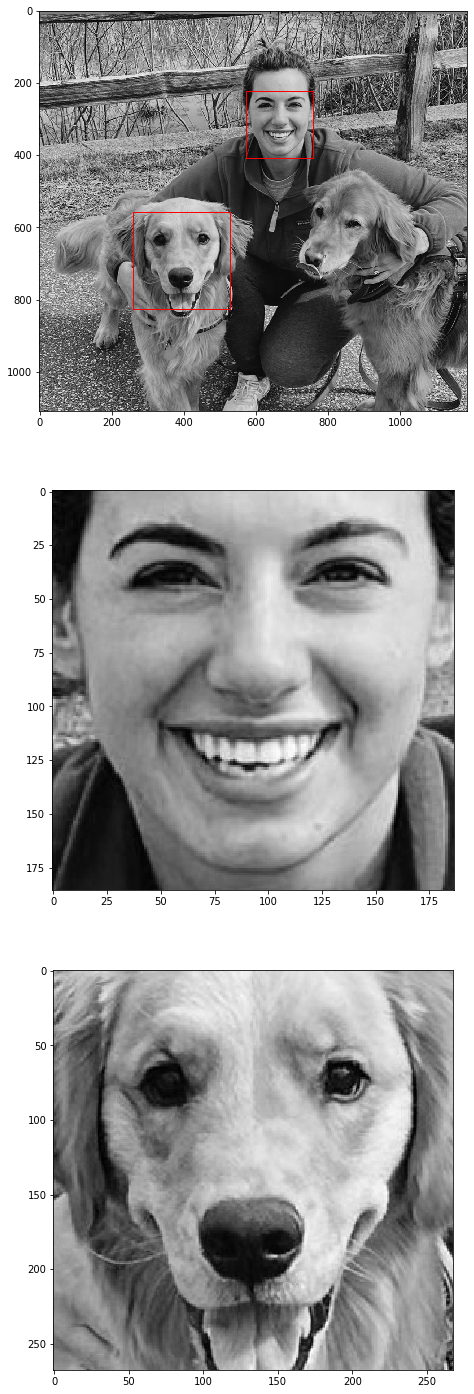

In [7]:
# detect faces in the grayscale image
rects = detector(gray, 1)
fig,plot = plt.subplots(3)
fig.set_size_inches(25,25)
plot[0].imshow(gray, cmap="gray")
for i,rect in enumerate(rects):
    rect=patches.Rectangle((rects[i].bl_corner().x,rects[i].tl_corner().y),rects[i].width(),rects[i].height(),linewidth=1,edgecolor='r',facecolor='none')
    plot[0].add_patch(rect)
    
    left_i=rects[i].tl_corner().x
    width=rects[i].width()
    top_i=rects[i].tl_corner().y
    height=rects[i].height()
    
    plot[i+1].imshow(gray[top_i:top_i+height,left_i:left_i+width],cmap="gray")
    # Create a Rectangle patch
plt.show()

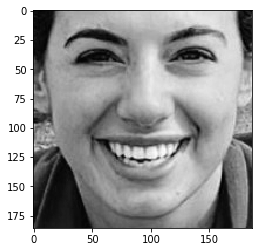

Now we have our M matrix for SVD
M is an nxm matrix where:
      n = 186
      m = 187
[[20 12 13 ... 27 16 11]
 [23 20 18 ... 34 23 13]
 [21 20 19 ... 38 37 30]
 ...
 [22 65 58 ... 32 36 40]
 [32 72 56 ... 37 39 40]
 [42 74 52 ... 40 39 38]]


In [8]:
left_i=rects[0].tl_corner().x
width=rects[0].width()
top_i=rects[0].tl_corner().y
height=rects[0].height()
face=gray[top_i:top_i+height,left_i:left_i+width]
plt.imshow(face,cmap="gray")
plt.show()  
print("Now we have our M matrix for SVD")
print("""M is an nxm matrix where:
      n = {0}
      m = {1}""".format(face.shape[0],face.shape[1]))
print(face)

Often times we use SVD to reduce the file size. This is possible because not all data in the image is necessary. We execute SVD below after normalizing the image by dividing by 256 (8 bit). 

In [9]:
U,Sigma,Vt = np.linalg.svd(face/255)
print("""Applying SVD we will find U, Sigma, and V matricies:
    U is a {0} x {0} matrix
    Sigma is a scaling matrix with {2} diagonalized eigenvalues
    V is a {1} x {1} matrix
Now: M = U Sigma V^T
""".format(U.shape[0],Vt.shape[0],Sigma.size))

Applying SVD we will find U, Sigma, and V matricies:
    U is a 186 x 186 matrix
    Sigma is a scaling matrix with 186 diagonalized eigenvalues
    V is a 187 x 187 matrix
Now: M = U Sigma V^T



Text(0.5, 1.0, '9 Dimensional Image')

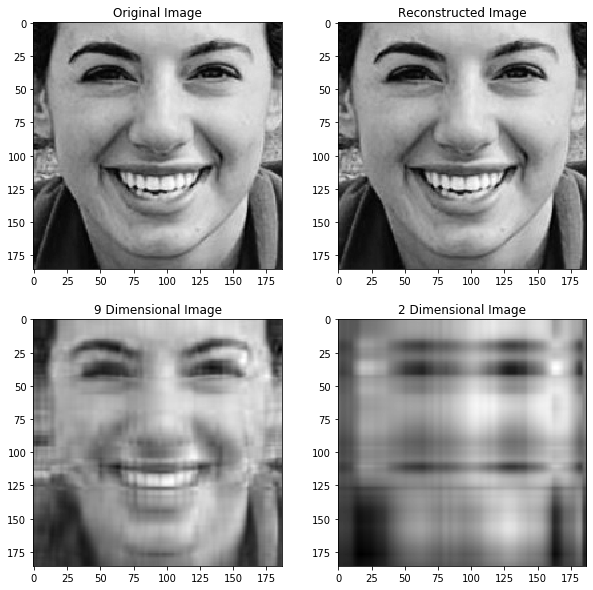

In [10]:
reconstructed_image=np.dot(np.dot(U,np.append(np.diag(Sigma),np.zeros(len(Sigma)).reshape(len(Sigma),1),axis=1)),Vt)
fig,plot = plt.subplots(2,2)
fig.set_size_inches(10,10)
plot[0,0].imshow(face,cmap="gray")
plot[0,0].set_title("Original Image")
plot[0,1].imshow(reconstructed_image,cmap="gray")
plot[0,1].set_title("Reconstructed Image")
plot[1,1].imshow(reduced_image(U,Sigma,Vt,2),cmap="gray")
plot[1,1].set_title("2 Dimensional Image")
plot[1,0].imshow(reduced_image(U,Sigma,Vt,9),cmap="gray")
plot[1,0].set_title("9 Dimensional Image")

The image can be reconstructed with less data by reducing the number of dimensions. The next figures are the same image with only 2-15 dimensions of data preserved

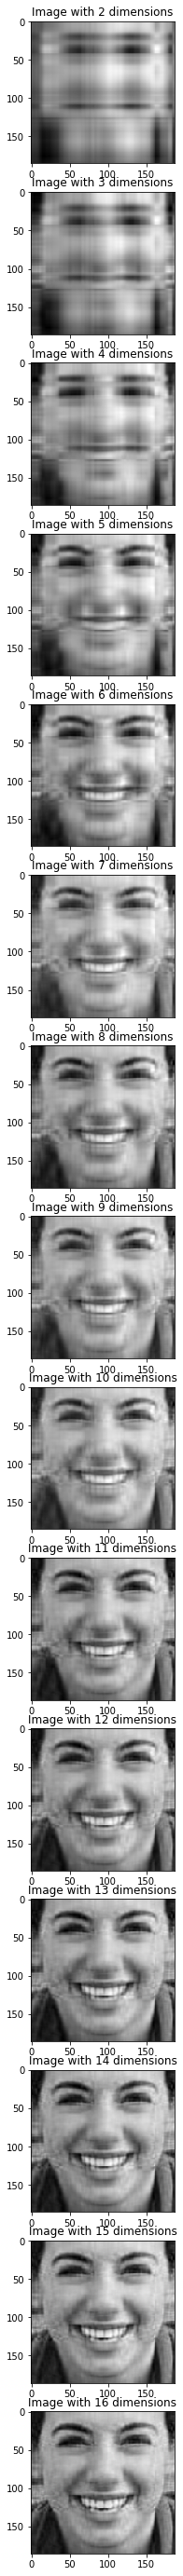

In [11]:
fig,plot = plt.subplots(15)
fig.set_size_inches(50,50)
for i in range(1,16):
    img=reduced_image(U,Sigma,Vt,i+1)
    plot[i-1].imshow(img,cmap="gray")
    plot[i-1].set_title('Image with {} dimensions'.format(i+1))
    

Now lets put everything together by applying facial regonition to each face. As a benchmark we have the x-y position of each 68 facial features from the full resolution image. The loop will calculate the x-y location of the compressed image and compare it to the uncompressed locations to evaluate the acuracy.

In [12]:
def return68(image):
    """returns (x,y) location of 68 features from dlib facial recognition after user passes in a grayscale image as numpy array.
    May find a smaller bounding box around shape"""
    image=image.astype(np.uint8)
    rects=detector(image,1)
    shape = predictor(image,rects[0])
    return face_utils.shape_to_np(shape)   
def markup(image,rect,shape):
    image.astype(np.uint8)
    (x, y, w, h) = face_utils.rect_to_bb(rect)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    # loop over the (x, y)-coordinates for the facial landmarks
    # and draw them on the image
    for (x, y) in shape:
        cv2.circle(image, (x, y), 1, (0, 0, 255), -1)
    return image

Here is the original image with 68 features in black


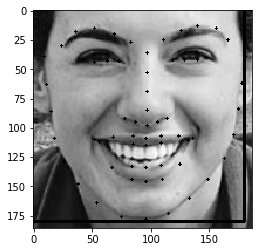

In [13]:
rects = detector(face, 1)
shape = return68(face)
Original_Shape=shape
(x, y, w, h) = face_utils.rect_to_bb(rects[0])
cv2.rectangle(face, (x, y), (x + w, y + h), (0, 255, 0), 2)
    # loop over the (x, y)-coordinates for the facial landmarks
    # and draw them on the image
for (x, y) in shape:
    cv2.circle(face, (x, y), 1, (0, 0, 255), -1)
plt.imshow(face,cmap='gray')
print("Here is the original image with {} features in black".format(len(shape)))

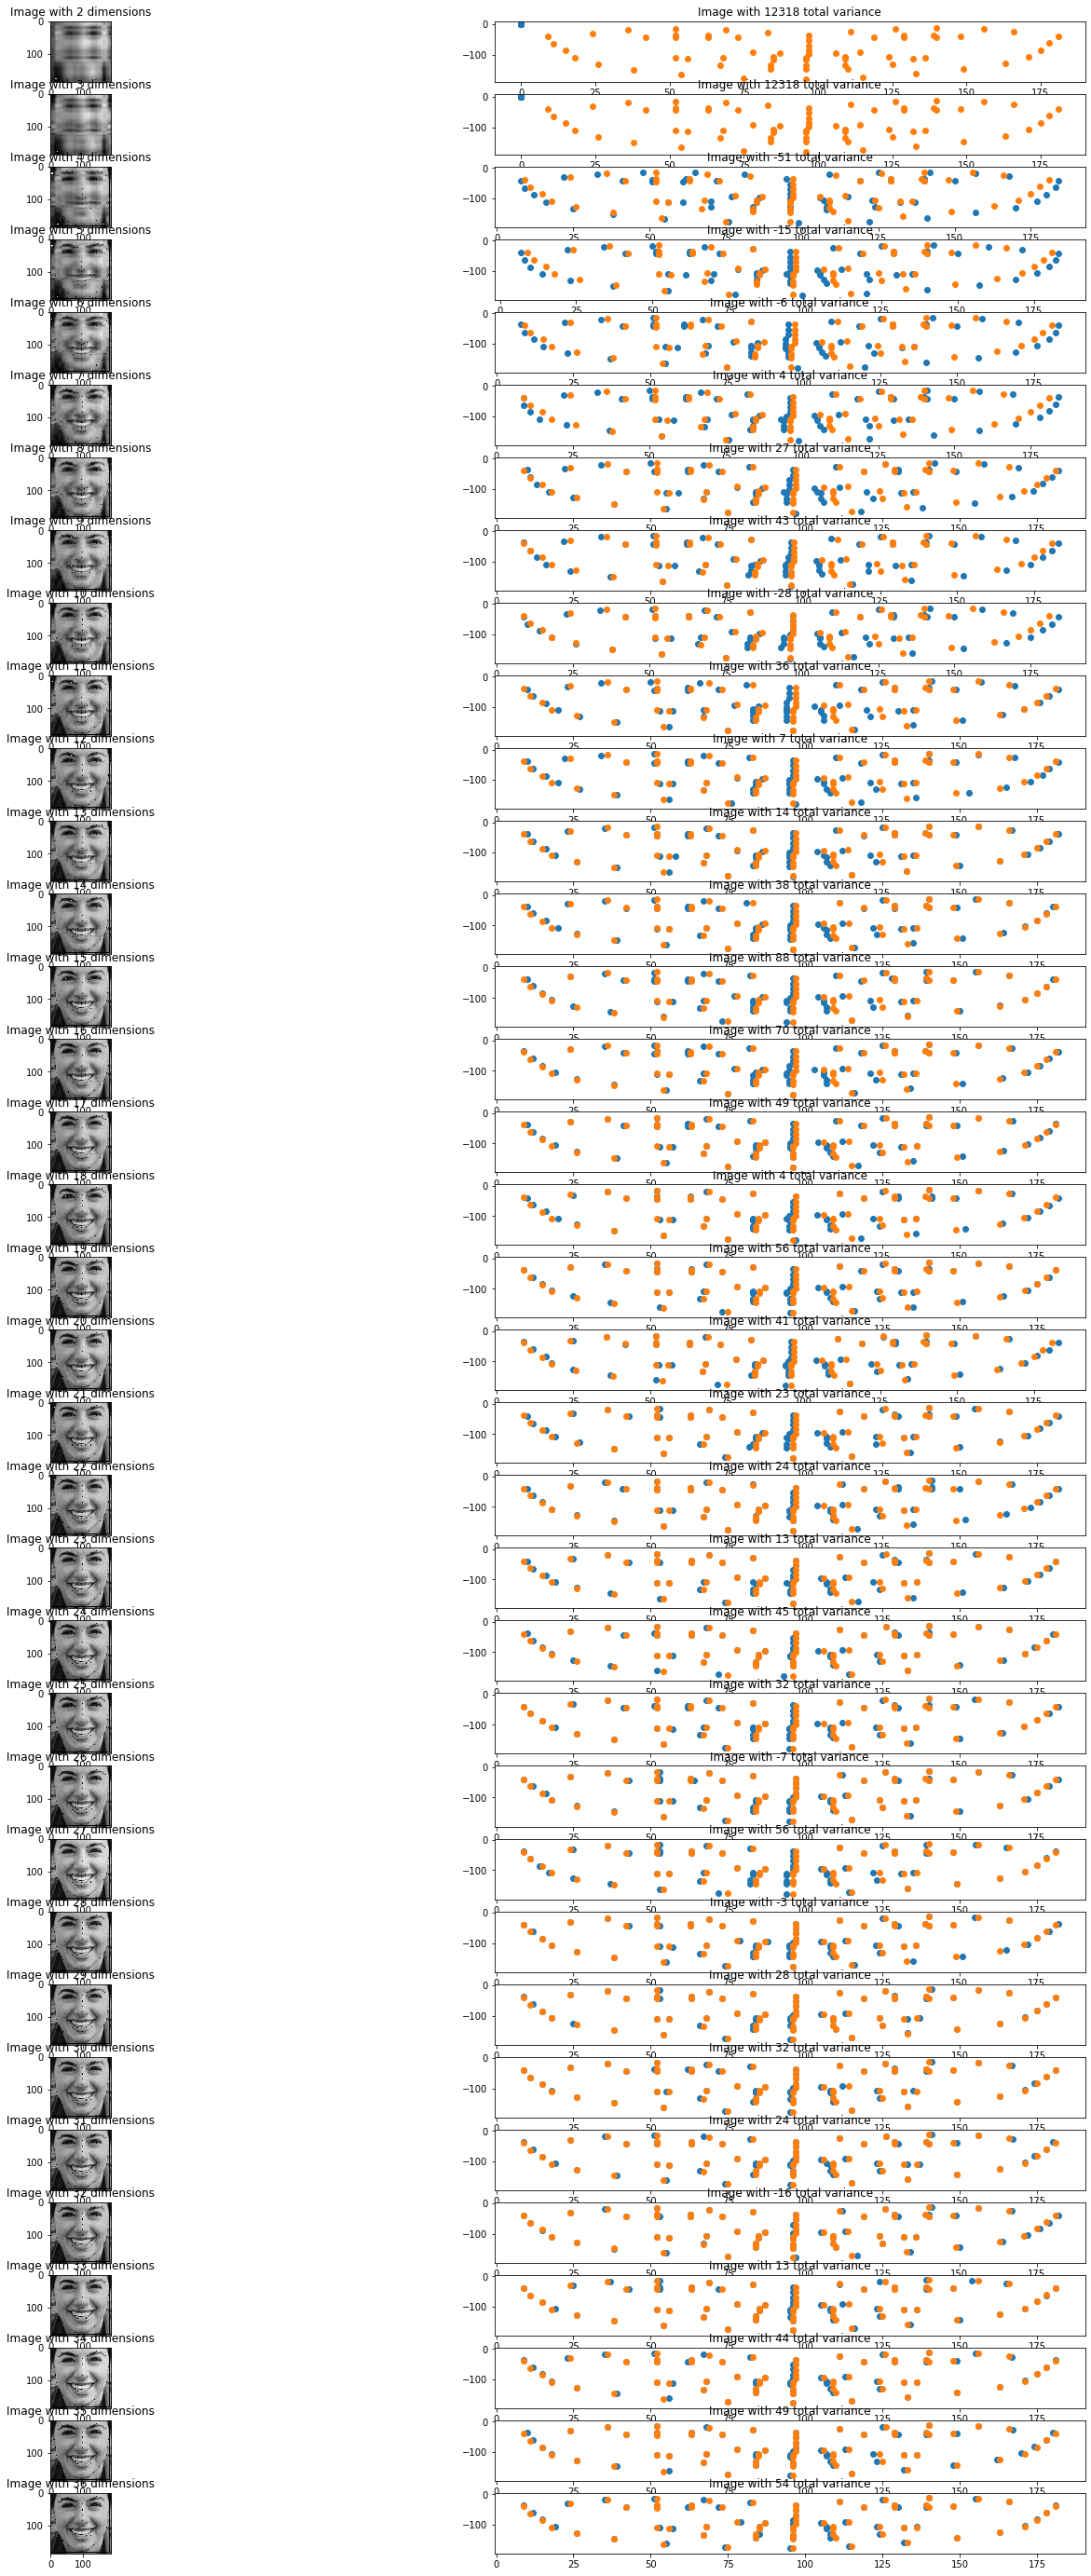

In [15]:
fig,plot = plt.subplots(35,2)
fig.set_size_inches(25,50)
Scat=np.asarray(list(zip(*Original_Shape)))
err=[]
for i in range(1,36):
    img=reduced_image(U,Sigma,Vt,i+1)
    img=img*256
    img=img.astype(np.uint8)
    #Now locate 68 features of reduced image
    try:
        shape = return68(img)
        img=markup(img,rects[0],shape)
    except: 
        shape = return68(face)*0
    #img=markup(img,rects[0],shape)
    
    
    plot[i-1,0].imshow(img,cmap="gray")
    plot[i-1,0].set_title('Image with {} dimensions'.format(i+1))
    scat=np.asarray(list(zip(*shape)))
    if np.sum(shape)!=0:
        err.append([i+1,np.sum(Scat-scat)])
    plot[i-1,1].scatter(scat[0],-scat[1])
    plot[i-1,1].scatter(Scat[0],-Scat[1])
    plot[i-1,1].set_title('Image with {} total variance'.format(np.sum(Scat-scat)))
    
    
    

In [16]:
Scat=np.asarray(list(zip(*Original_Shape)))
err=[]
for i in range(1,186):
    img=reduced_image(U,Sigma,Vt,i+1)
    img=img*256
    img=img.astype(np.uint8)
    #Now locate 68 features of reduced image
    try:
        shape = return68(img)
        img=markup(img,detector(img, 1)[0],shape)
    except: 
        shape = return68(face)*0
    scat=np.asarray(list(zip(*shape)))
    if np.sum(shape)!=0:
        err.append([i+1,np.sum(np.power(Scat-scat,2))])

    
    
    

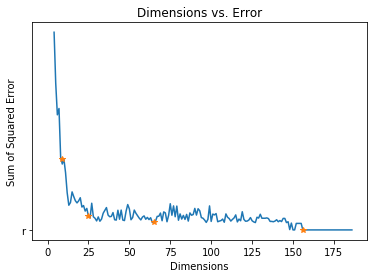

In [17]:
plt.plot(np.asarray(err)[:,0],np.asarray(err)[:,1])
plt.plot([9,25,65,156],[np.asarray(err)[:,1][6],np.asarray(err)[:,1][21],np.asarray(err)[:,1][61],np.asarray(err)[:,1][152]],'*', 'r')
plt.title("Dimensions vs. Error")
plt.xlabel("Dimensions")
plt.ylabel("Sum of Squared Error")
plt.show()
#plt.xlabel("test")

I am no longer admitting defeat as that graph is AWESOME

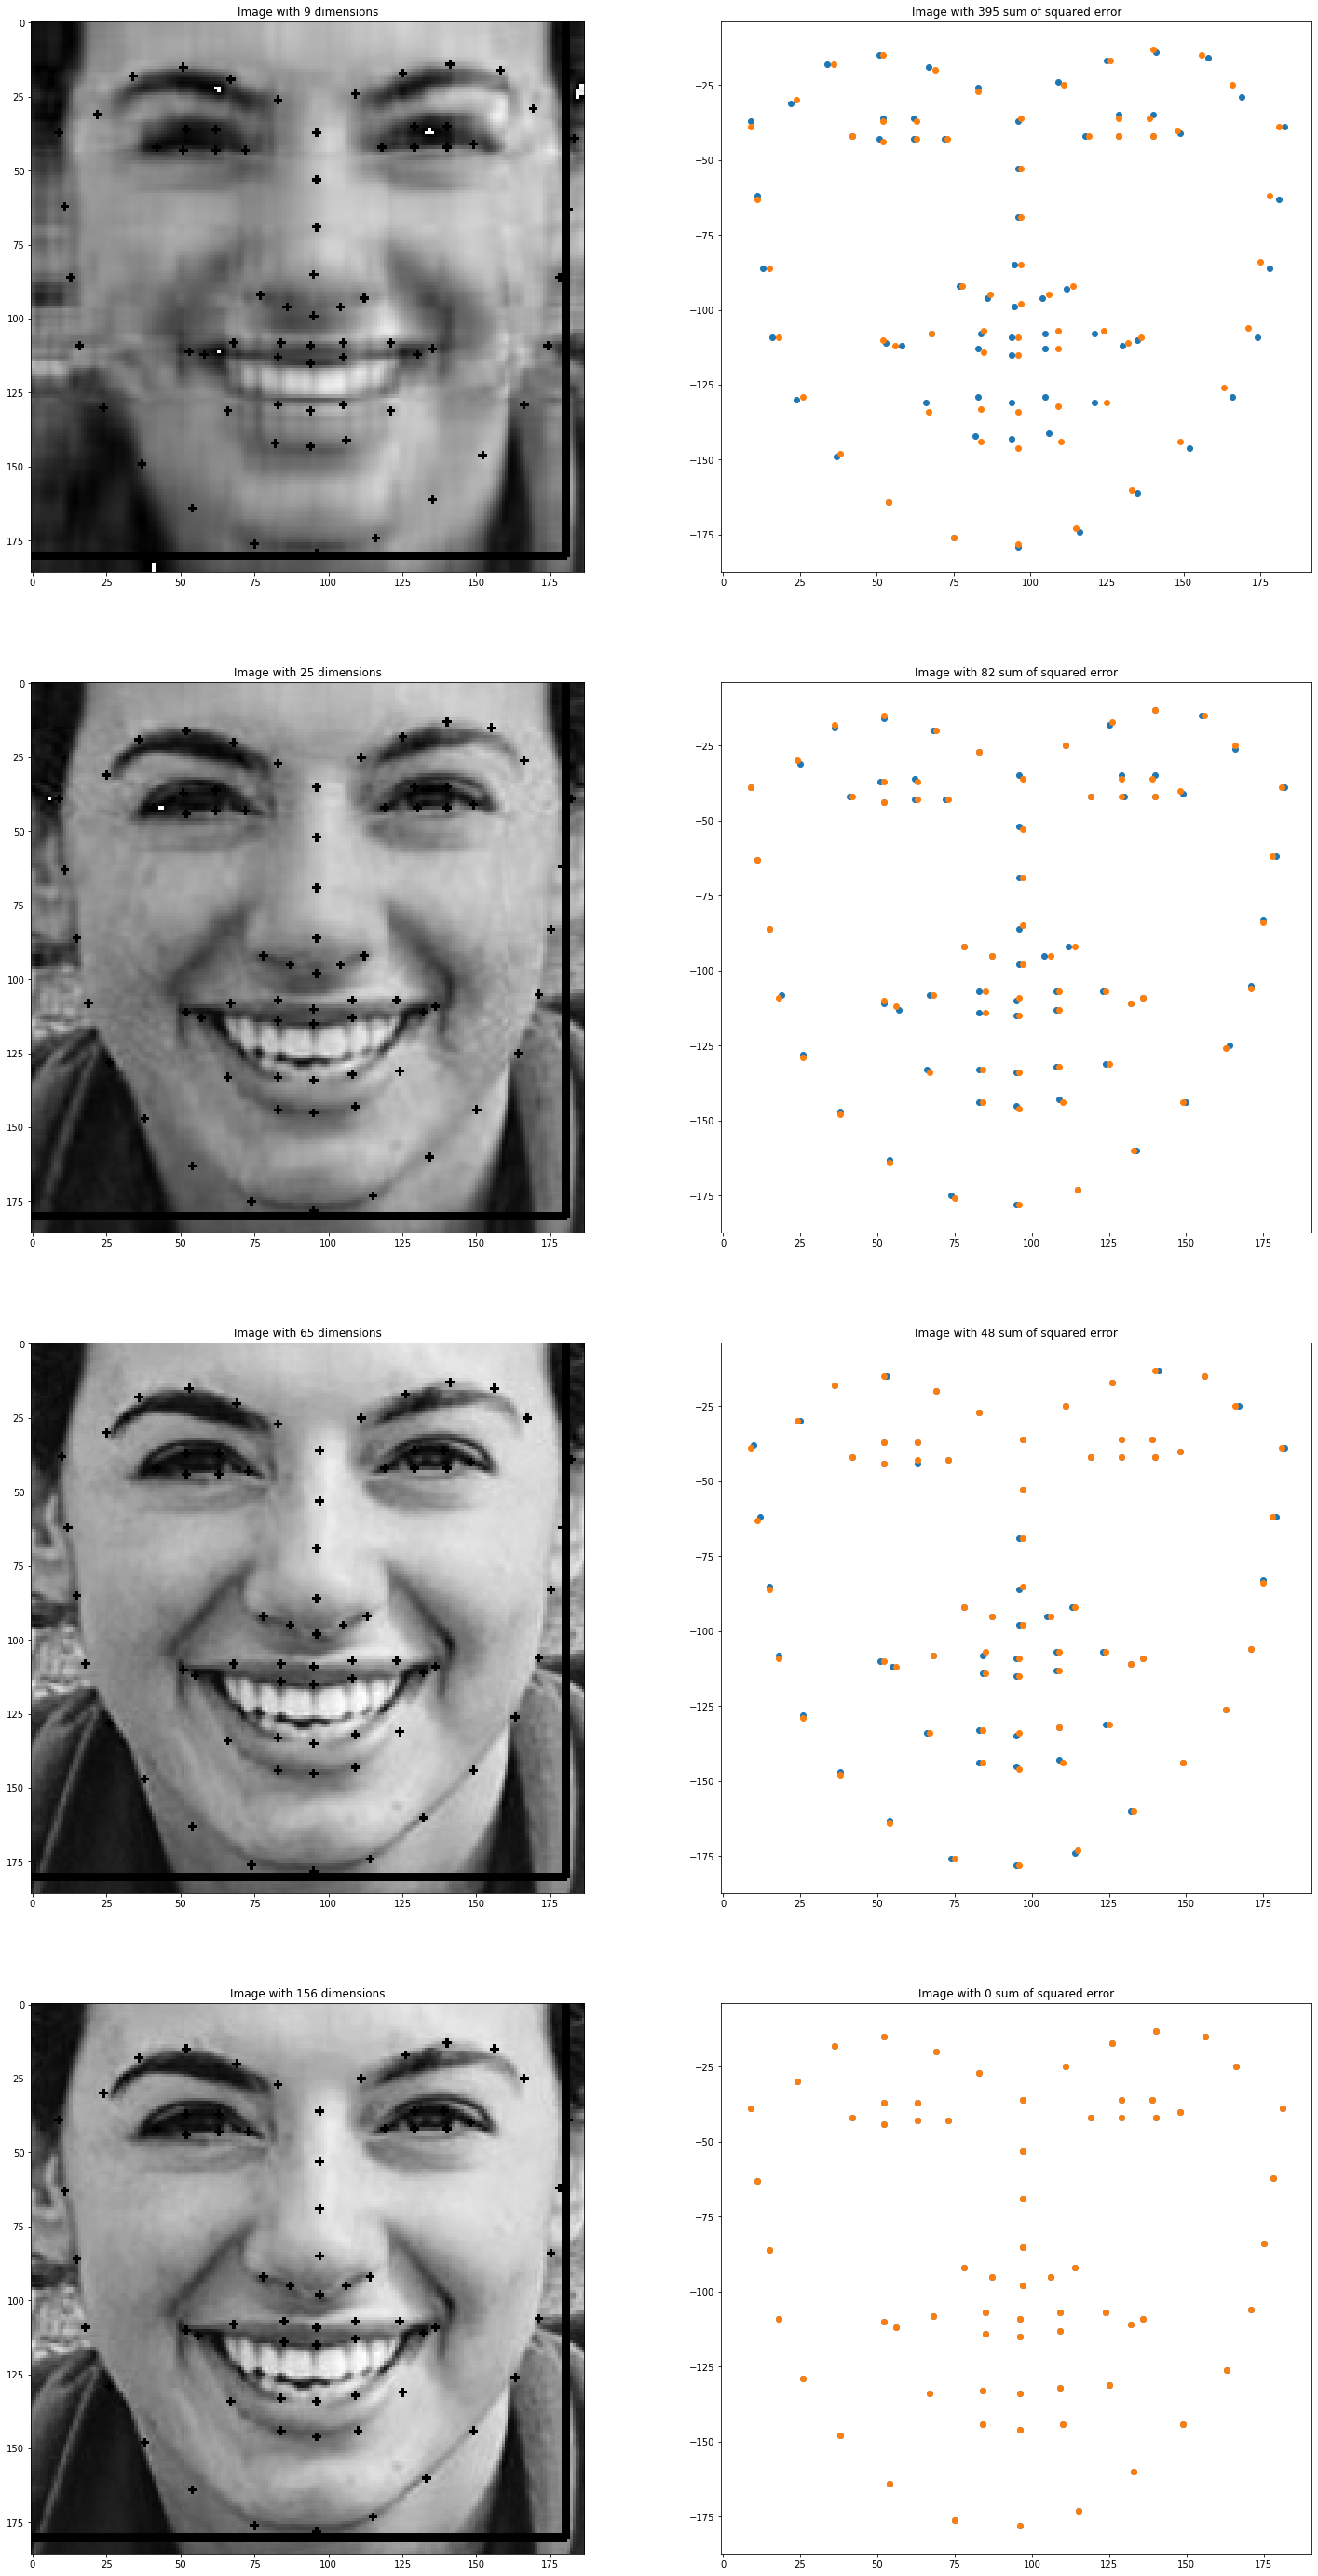

In [18]:
fig,plot = plt.subplots(4,2)
fig.set_size_inches(25,50)
Scat=np.asarray(list(zip(*Original_Shape)))
err=[]
for j,i in enumerate([8,24,64,155]):
    img=reduced_image(U,Sigma,Vt,i+1)
    img=img*256
    img=img.astype(np.uint8)
    #Now locate 68 features of reduced image
    try:
        shape = return68(img)
        img=markup(img,rects[0],shape)
    except: 
        shape = return68(face)*0
    #img=markup(img,rects[0],shape)
    
    
    plot[j,0].imshow(img,cmap="gray")
    plot[j,0].set_title('Image with {} dimensions'.format(i+1))
    scat=np.asarray(list(zip(*shape)))
    if np.sum(shape)!=0:
        err.append([i+1,np.sum(Scat-scat)])
    plot[j,1].scatter(scat[0],-scat[1])
    plot[j,1].scatter(Scat[0],-Scat[1])
    plot[j,1].set_title('Image with {} sum of squared error'.format(np.sum(np.power(Scat-scat,2))))

In [19]:
from sklearn.decomposition import PCA

In [20]:
pca=PCA()

In [21]:
pca.fit(face/255)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [23]:

var_tot=sum(pca.explained_variance_)
tot=0
for i in range(len(pca.explained_variance_)):
    tot=tot+pca.explained_variance_[i]/var_tot
    if tot>.85:
        print(i)
        break

6


In [25]:

var_tot=sum(pca.explained_variance_)
tot=0
t=[]
for i in range(len(pca.explained_variance_)):
    tot=tot+pca.explained_variance_[i]/var_tot
    t.append(tot)


Text(0.5, 1.0, 'Total variance explained by each dimension')

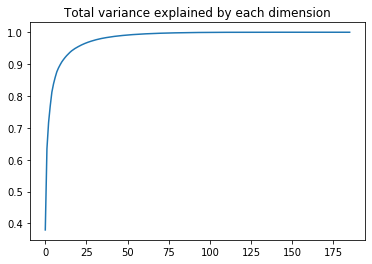

In [26]:
plt.plot(t)
plt.title("Total variance explained by each dimension")

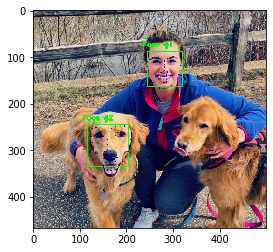